In [25]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import json
import os
import random
import math
import cv2
import pandas as pd
import torch
import ast
from matplotlib.patches import Rectangle
%matplotlib inline

In [26]:
def plot(img, points=None):
    if isinstance(img, str):
        img = Image.open(img)
    plt.imshow(img)
    if points:
        for p in points:
            plt.scatter(p[0], p[1], color='red', s=10)
    plt.axis('off')
    plt.show()

def plot_bbox(image, bbox, cap, p1=None, p2=None, mask=None, alpha=0.4):
    if isinstance(image, str):
        image = Image.open(image)
    plt.figure()  # This creates a new figure every time
    ax = plt.gca()
    ax.imshow(image)

    # Draw bounding box
    if isinstance(bbox[0],list):
        for _ in bbox:
            box_plot = Rectangle((_[0], _[1]), _[2], _[3],
                                 fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(box_plot)
    else:
        box_plot = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(box_plot)

    # Draw points if provided
    if p1:
        plt.scatter(p1[0], p1[1], color='blue', s=50)
    if p2:
        plt.scatter(p2[0], p2[1], color='red', s=50)

    plt.title(cap)
    plt.axis('off')  # Optional: clean display
    plt.tight_layout()
    plt.show()

In [14]:
data_dir = "/home/manugaur/vlm_obj_det/dataset"
for split in ['test', "train", "valid"]:
    data = json.load(open(os.path.join(data_dir, f"{split}", "_annotations.coco.json"), "r"))
    print(f"{split} split has ({len(data['images'])} images, {len(data['annotations'])} annotations)")

test split has (70 images, 444 annotations)
train split has (89 images, 100 annotations)
valid split has (61 images, 99 annotations)


In [15]:
"""
image UID: images --> id | annotations --> image_id
ann UID: annotations --> i
annotations['bbox'] = x1, y1, w, h | top left point and bbox dim
"""
split = 'test'
data = json.load(open(os.path.join(data_dir, f"{split}", "_annotations.coco.json"), "r"))
print(data.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [16]:
# data['images'][0]

In [17]:
# data['annotations'][-1]

In [18]:
# class_id_to_name = {i['id']: i['name'] for i in data['categories']}
# class_id_to_name[0]=None
# print(class_id_to_name)



In [19]:
# data.keys()

#### dict: image_id --> list of bbox annotations

In [20]:
image_id_to_bbox = defaultdict(list)
for ann in data['annotations']:
    image_id = ann['image_id']
    # if image_id in image_id_to_bbox:
    image_id_to_bbox[image_id].append((ann['bbox'], ann['category_id']-1))


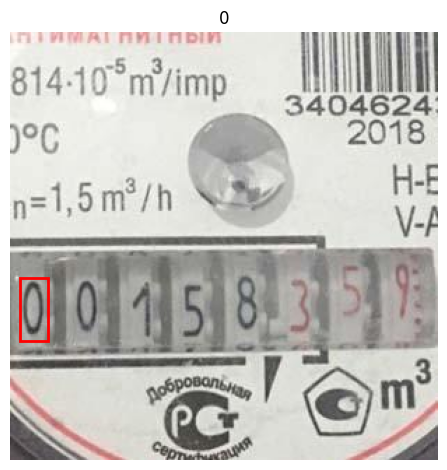

In [21]:
image = random.sample(data['images'],1)[0]
file_name = image['file_name'] 
image_id = image['id']
image_path = os.path.join(data_dir, split, file_name)
for ann in image_id_to_bbox[image_id]:
    bbox, target = ann
    plot_bbox(image_path, bbox, target)
    break

## Roboflow dataset

In [27]:
from PIL import Image

from train import download_dataset, RoboflowDataset
ds = download_dataset("4BDHggHM6vkVOoK3g0s3", "objectdetvlm", "water-meter-jbktv-7vz5k-fsod-ftoz-qii9s", 1)
datasets = {
    "train": RoboflowDataset(ds.location,"train"),
    "valid": RoboflowDataset(ds.location,"valid"),
    "test": RoboflowDataset(ds.location,"test"),
}

loading Roboflow workspace...
loading Roboflow project...


In [28]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2",
    revision="2025-06-21",
    trust_remote_code=True,
    device_map={"": "cuda"}
)

def denorm_pixel(box, width, height):
    x_min = min(int(box['x_min'] * width), width - 1)
    x_max = min(int(box['x_max'] * width), width - 1)
    y_min = min(int(box['y_min'] * height), height - 1)
    y_max = min(int(box['y_max'] * height), height - 1)

    x_min = max(0, x_min); y_min = max(0, y_min)
    if x_max < x_min: x_max = x_min
    if y_max < y_min: y_max = y_min
    return {'x_min_px': x_min, 'y_min_px': y_min,
            'x_max_px': x_max, 'y_max_px': y_max}

In [30]:
ds = datasets["test"]
for image_idx in range(len(ds)):
# image_idx = random.randint(0, len(ds))
    image, ann = ds.__getitem__(image_idx)
    w,h = image.size
    for class_id, bbox_list in ann.items():
        print(class_id)
        coco_bbox_list = []
        out = model.detect(image, "The digit " + str(class_id))
        preds = [list(denorm_pixel(pred, w, h).values()) for pred in out['objects']]
        print(preds)
        break
        for pred in preds:
            x_min, y_min, x_max, y_max = pred
            bbox_w = x_max - x_min
            bbox_h = y_max - y_min
            coco_bbox_list.append([x_min, y_min, bbox_w, bbox_h])
        plot_bbox(image,coco_bbox_list , class_id)
        break
            # print(f"-->{coco_bbox_list}")
    break


9
[[14, 119, 32, 161], [58, 120, 75, 163], [148, 124, 163, 166], [189, 143, 204, 184]]


In [6]:
ds = datasets["test"] # len(ds) --> num_images
for image_idx in range(len(ds)):
# image_idx = random.randint(0, len(ds))
    image, ann = ds.__getitem__(image_idx)
    for class_id, bbox_list in ann.items():
        coco_bbox_list = []
        for bbox in bbox_list:
            
        plot_bbox(image,coco_bbox_list, class_id)
    print("--"*100)